In [194]:
from torch.utils.data import DataLoader
# import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [2]:
%matplotlib inline

In [56]:
%run dataset.py

## Common

In [120]:
ALL_DISEASES = [ "Atelectasis",
                 "Cardiomegaly",
                 "Effusion",
                 "Infiltration",
                 "Mass",
                 "Nodule",
                 "Pneumonia",
                 "Pneumothorax",
                 "Consolidation",
                 "Edema",
                 "Emphysema",
                 "Fibrosis",
                 "Pleural_Thickening",
                 "Hernia"]

In [6]:
base_dir = "/mnt/data/chest-x-ray-8"

In [177]:
def get_labels_as_string(labels, sep="|"):
    """Receives an array of 0s or 1s, returns the present disease names."""
    
    label_string = ""
    if sum(labels) == 0:
        return "Normal"
    
    present_diseases = [ALL_DISEASES[index] for index, present in enumerate(labels) if present]
    
    return sep.join(present_diseases)

## Load labels

In [126]:
labels_fname = base_dir + "/dataset/label_index.csv"
labels_index = pd.read_csv(labels_fname, header=0)
print(labels_index.shape)
labels_index.head()

(112120, 15)


,FileName,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,00000001_002.png,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [127]:
N_IMAGES, n_cols = labels_index.shape
print("Amount of images: ", N_IMAGES)
print("Amount of diseases: ", len(ALL_DISEASES))

Amount of images:  112120
Amount of diseases:  14


## Load bbox list

In [49]:
bbox_fname = base_dir + "/dataset/BBox_List_2017.csv"
bbox_index = pd.read_csv(bbox_fname, header=0)
bbox_index.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [50]:
images_with_bbox = set(bbox_index["Image Index"])
sorted(images_with_bbox)

['00000032_037.png',
 '00000072_000.png',
 '00000147_001.png',
 '00000149_006.png',
 '00000150_002.png',
 '00000181_061.png',
 '00000193_019.png',
 '00000211_010.png',
 '00000211_016.png',
 '00000211_019.png',
 '00000211_041.png',
 '00000344_003.png',
 '00000377_004.png',
 '00000398_003.png',
 '00000457_004.png',
 '00000468_017.png',
 '00000468_033.png',
 '00000468_041.png',
 '00000506_013.png',
 '00000583_008.png',
 '00000643_002.png',
 '00000661_000.png',
 '00000732_005.png',
 '00000740_000.png',
 '00000744_006.png',
 '00000756_001.png',
 '00000808_002.png',
 '00000830_000.png',
 '00000845_000.png',
 '00000865_006.png',
 '00000902_001.png',
 '00001039_005.png',
 '00001075_024.png',
 '00001153_004.png',
 '00001170_046.png',
 '00001248_038.png',
 '00001320_003.png',
 '00001369_000.png',
 '00001373_009.png',
 '00001373_039.png',
 '00001437_012.png',
 '00001534_005.png',
 '00001555_002.png',
 '00001558_016.png',
 '00001673_016.png',
 '00001688_000.png',
 '00001787_008.png',
 '00001836_04

### Amount of bboxes per image

In [105]:
bbox_index.groupby("Image Index").count()["Finding Label"].sort_values(ascending=False)

Image Index
00010277_000.png    4
00018427_004.png    3
00021703_001.png    3
00012376_010.png    3
00018253_059.png    3
00013659_019.png    3
00005066_030.png    3
00008814_010.png    3
00020482_032.png    3
00010828_039.png    3
00028640_008.png    2
00028285_014.png    2
00008841_025.png    2
00003440_000.png    2
00017138_037.png    2
00002106_000.png    2
00013993_077.png    2
00013993_083.png    2
00020124_003.png    2
00020405_041.png    2
00028208_005.png    2
00020393_003.png    2
00012021_081.png    2
00017582_003.png    2
00028383_002.png    2
00020259_002.png    2
00020000_000.png    2
00025787_027.png    2
00017500_002.png    2
00009437_008.png    2
                   ..
00019124_104.png    1
00019124_090.png    1
00019124_045.png    1
00019124_006.png    1
00019646_006.png    1
00019651_002.png    1
00019706_002.png    1
00019706_012.png    1
00020318_007.png    1
00020277_001.png    1
00020274_021.png    1
00020213_078.png    1
00020184_013.png    1
00020146_005.png    

## Plot images with bbox

### Available images

Not all images may be present on the folder

In [144]:
available_images = os.listdir(base_dir + "/dataset/images")
available_images.sort()
available_images

['00000001_000.png',
 '00000001_001.png',
 '00000001_002.png',
 '00000002_000.png',
 '00000003_000.png',
 '00000003_001.png',
 '00000003_002.png',
 '00000003_003.png',
 '00000003_004.png',
 '00000003_005.png',
 '00000003_006.png',
 '00000003_007.png',
 '00000004_000.png',
 '00000005_000.png',
 '00000005_001.png',
 '00000005_002.png',
 '00000005_003.png',
 '00000005_004.png',
 '00000005_005.png',
 '00000005_006.png',
 '00000005_007.png',
 '00000006_000.png',
 '00000007_000.png',
 '00000008_000.png',
 '00000008_001.png',
 '00000008_002.png',
 '00000009_000.png',
 '00000010_000.png',
 '00000011_000.png',
 '00000011_001.png',
 '00000011_002.png',
 '00000011_003.png',
 '00000011_004.png',
 '00000011_005.png',
 '00000011_006.png',
 '00000011_007.png',
 '00000011_008.png',
 '00000012_000.png',
 '00000013_000.png',
 '00000013_001.png',
 '00000013_002.png',
 '00000013_003.png',
 '00000013_004.png',
 '00000013_005.png',
 '00000013_006.png',
 '00000013_007.png',
 '00000013_008.png',
 '00000013_00

### Available images with bbox

In [145]:
images_avail_bbox = images_with_bbox.intersection(set(available_images))
images_avail_bbox

{'00000032_037.png',
 '00000072_000.png',
 '00000147_001.png',
 '00000149_006.png',
 '00000150_002.png',
 '00000181_061.png',
 '00000193_019.png',
 '00000211_010.png',
 '00000211_016.png',
 '00000211_019.png',
 '00000211_041.png',
 '00000344_003.png',
 '00010277_000.png',
 '00018253_059.png',
 '00018427_004.png'}

In [151]:
# example_image_bbox = list(images_avail_bbox)[0]

example_image_bbox = "00010277_000.png"
example_image_bbox = "00018427_004.png"
# example_image_bbox = "00018253_059.png"
example_image_bbox

'00018427_004.png'

### Get image

In [190]:
def get_image_fname(name):
    return base_dir + "/dataset/images/" + name

In [192]:
fname = get_image_fname(example_image_bbox)
image = Image.open(fname).convert("RGB")
image.size

(1024, 1024)

### Get bbox

In [241]:
rows = bbox_index.loc[bbox_index["Image Index"]==example_image_bbox]

bboxes = []
for _, row in rows.iterrows():
    label, x, y, w, h = row[1:6]
    bboxes.append((label, x, y, w, h))

rows

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
120,00018427_004.png,Atelectasis,94.273016,631.737566,177.710053,72.601058,NaN,NaN,NaN
457,00018427_004.png,Effusion,770.438095,351.085714,184.211640,548.300529,NaN,NaN,NaN
634,00018427_004.png,Mass,532.046561,328.330159,107.276190,100.774603,NaN,NaN,NaN


In [247]:
colors = ["red", "blue", "cyan", "green"]

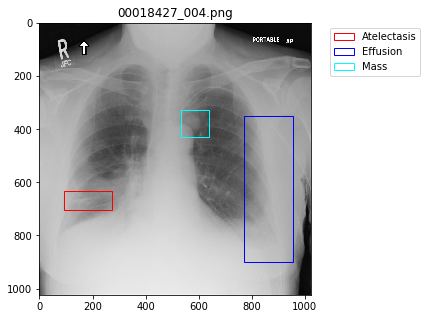

In [248]:
plt.figure(figsize=(5, 5))

plt.imshow(image)
plt.title(example_image_bbox)
ax = plt.gca()

for index, bbox in enumerate(bboxes):
    label, x, y, width, height = bbox
    
    color = colors[index]
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor=color, facecolor="none", label=label)
    ax.add_patch(rect)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

### Plot as grid

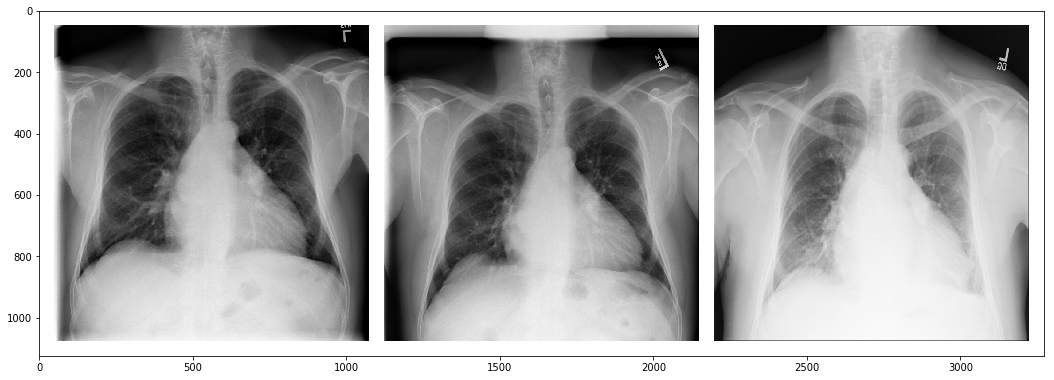

In [238]:
plt.figure(figsize=(18, 16))

image_names = available_images[:3]

tensor_images = []
for image_name in image_names:
    pil_image = Image.open(get_image_fname(image_name))
    tensor_image = transforms.ToTensor()(pil_image)
    tensor_images.append(tensor_image)

image_grid = make_grid(tensor_images, padding=50, pad_value=1)
plt.imshow(np.transpose(image_grid, (1, 2, 0)))

## Load data with `CXRDataset`

In [156]:
train_dataset = CXRDataset(base_dir + "/dataset", dataset_type="train")

In [164]:
image, labels, image_fname, bboxes, bboxes_valid = train_dataset[2]
print("Image fname: ", image_fname)
print("Image size: ", image.size())
print("Labels: ", labels)
print(bboxes.size())
print(bboxes_valid)

Image fname:  00000001_002.png
Image size:  torch.Size([1, 1024, 1024])
Labels:  [0 1 1 0 0 0 0 0]
torch.Size([8, 4])
tensor([0., 0., 0., 0., 0., 0., 0., 0.])


Labeled with:  Cardiomegaly, Effusion


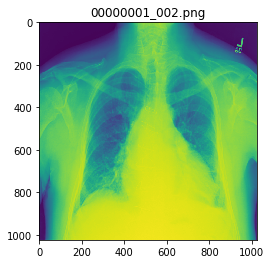

In [168]:
plt.title(image_fname)
plt.imshow(image[0]) # Get first dimension of the tensor
print("Labeled with: ", get_labels_as_string(labels, sep=", "))

## Disease analysis

### Instances per disease

In [170]:
labels_index[ALL_DISEASES].sum().sort_values(ascending=False)

Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
dtype: int64

### Consider multiple diseases

In [180]:
def merge_diseases_names(row):
    diseases_present = row[ALL_DISEASES]

    full_disease = get_labels_as_string(diseases_present)
    amount = sum(diseases_present)

    row["Full"] = full_disease
    row["Amount"] = amount

    return row

labels_analysis = labels_index.apply(merge_diseases_names, axis=1)
labels_analysis.head()

,FileName,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia,Full,Amount
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Cardiomegaly,1
1,00000001_001.png,0,1,0,0,0,0,0,0,0,0,1,0,0,0,Cardiomegaly|Emphysema,2
2,00000001_002.png,0,1,1,0,0,0,0,0,0,0,0,0,0,0,Cardiomegaly|Effusion,2
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Normal,0
4,00000003_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Hernia,1


---

Also see Figure 2 in paper, with proportions for each disease

In [181]:
# Amount of each class
counts = labels_analysis["Full"].value_counts()
counts

Normal                                                                                                  60361
Infiltration                                                                                             9547
Atelectasis                                                                                              4215
Effusion                                                                                                 3955
Nodule                                                                                                   2705
Pneumothorax                                                                                             2194
Mass                                                                                                     2139
Effusion|Infiltration                                                                                    1604
Atelectasis|Infiltration                                                                                 1350
Consolidat

In [187]:
# Only single diseases
counts.loc[ALL_DISEASES + ["Normal"]].sort_values(ascending=False)

Normal                60361
Infiltration           9547
Atelectasis            4215
Effusion               3955
Nodule                 2705
Pneumothorax           2194
Mass                   2139
Consolidation          1310
Pleural_Thickening     1126
Cardiomegaly           1093
Emphysema               892
Fibrosis                727
Edema                   628
Pneumonia               322
Hernia                  110
Name: Full, dtype: int64

In [186]:
amount_normal = counts.loc["Normal"]
amount_something = N_IMAGES - amount_normal
print("Normal images: ", amount_normal)
print("Images with disease: ", amount_something)

Normal images:  60361
Images with disease:  51759


## Old

#### Calculate mean, to normalize later

In [ ]:
from PIL import ImageStat

In [59]:
'''
dataset = CXRDataset('dataset', dataset_type='train')

mean = np.zeros(3)
for i in range(len(dataset)):
    image = dataset[i][0]
    stat = ImageStat.Stat(image)
    mean += np.array(stat.mean)
    print('\r{:.2f}%'.format(100*i/len(dataset)), end='\r')
mean /= len(dataset)*255
print(mean) # 0.50576189
'''
mean = 0.50576189
print(mean)

0.50576189
